# **MODELING AND EVALUATION NOTEBOOK**

## Objectives

* Answer business requirement 2:
    * he client is interested to tell whether a given image has powdery mildew or not.

## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file


---

## Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

## Set Working Directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspace/mildewproject')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildewproject'

---

### Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


### Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Number of images in train, test and validation data

* train - healthy: 295 images
* train - powdery_mildew: 1472 images
* validation - healthy: 42 images
* validation - powdery_mildew: 210 images
* test - healthy: 85 images
* test - powdery_mildew: 422 images




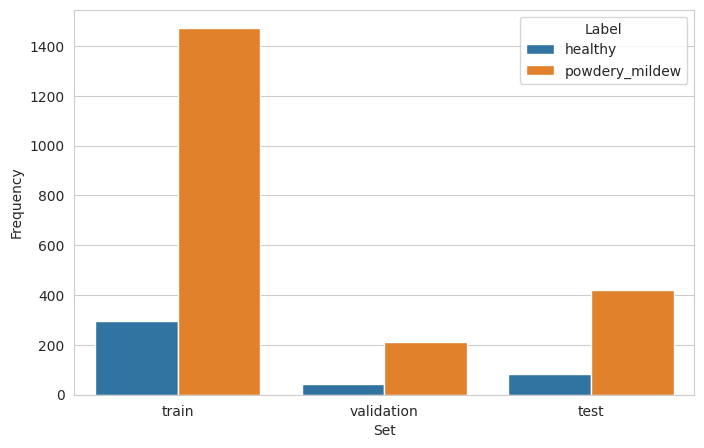

In [9]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

## Image Data Augmentation

### ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

* ### Augment training image dataset

In [12]:
batch_size = 20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 1767 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 252 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment test image dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 507 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training image

(20, 256, 256, 3)


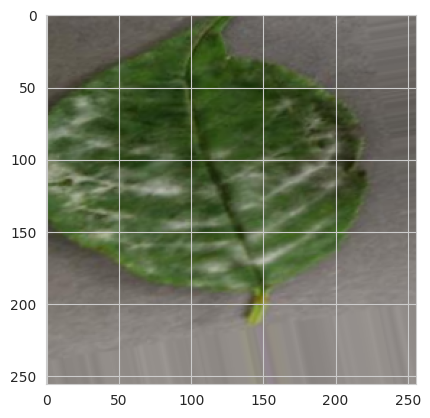

(20, 256, 256, 3)


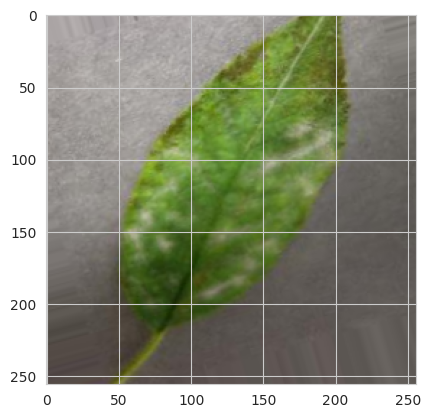

(20, 256, 256, 3)


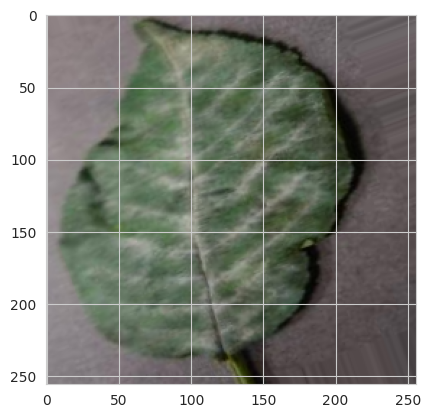

In [15]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


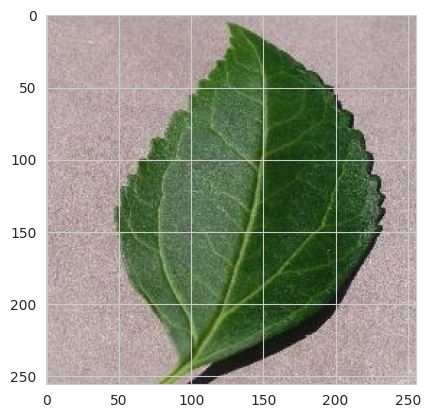

(20, 256, 256, 3)


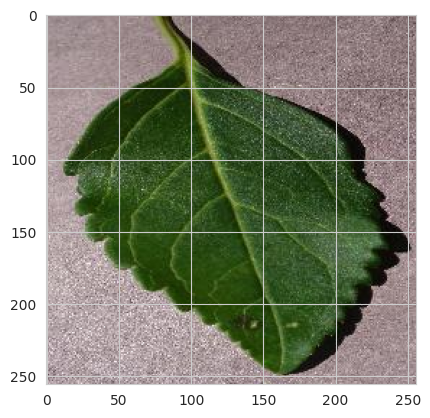

(20, 256, 256, 3)


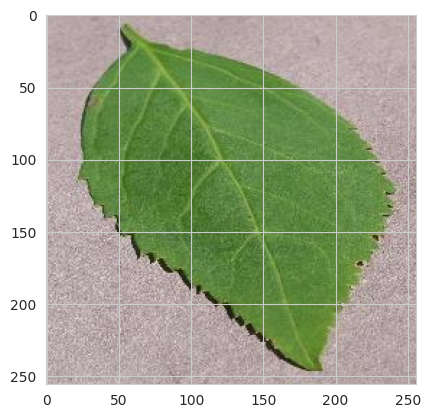

In [16]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [17]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model Creation

* ### Import model packages

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model

In [19]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

* ### Model Summary

In [20]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2022-09-19 15:17:19.073735: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Early Stopping

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

### Fit model for model training

In [22]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2022-09-19 15:18:11.938918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-09-19 15:18:12.816079: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 165160960 exceeds 10% of free system memory.
2022-09-19 15:18:14.640901: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 165160960 exceeds 10% of free system memory.


 1/88 [..............................] - ETA: 4:52 - loss: 0.6804 - accuracy: 0.6000

2022-09-19 15:18:15.327599: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 165160960 exceeds 10% of free system memory.
2022-09-19 15:18:17.418876: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 165160960 exceeds 10% of free system memory.


 2/88 [..............................] - ETA: 4:01 - loss: 0.5955 - accuracy: 0.7750

2022-09-19 15:18:18.135031: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 165160960 exceeds 10% of free system memory.


88/88 [==============================] - 231s 3s/step - loss: 0.4338 - accuracy: 0.8409 - val_loss: 0.2390 - val_accuracy: 0.8810
Epoch 2/25
88/88 [==============================] - 124s 1s/step - loss: 0.2145 - accuracy: 0.9227 - val_loss: 0.0376 - val_accuracy: 0.9960
Epoch 3/25
88/88 [==============================] - 98s 1s/step - loss: 0.0799 - accuracy: 0.9708 - val_loss: 0.0177 - val_accuracy: 0.9960
Epoch 4/25
88/88 [==============================] - 97s 1s/step - loss: 0.0477 - accuracy: 0.9845 - val_loss: 1.3430 - val_accuracy: 0.5476
Epoch 5/25
88/88 [==============================] - 95s 1s/step - loss: 0.1180 - accuracy: 0.9697 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/25
88/88 [==============================] - 106s 1s/step - loss: 0.0427 - accuracy: 0.9851 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/25
88/88 [==============================] - 137s 2s/step - loss: 0.0478 - accuracy: 0.9834 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 8/25
88/88 [=========

### Save model

In [23]:
model.save('outputs/v1/mildew_project_model.h5')

---

## Model Performance

---

### Model learning curve

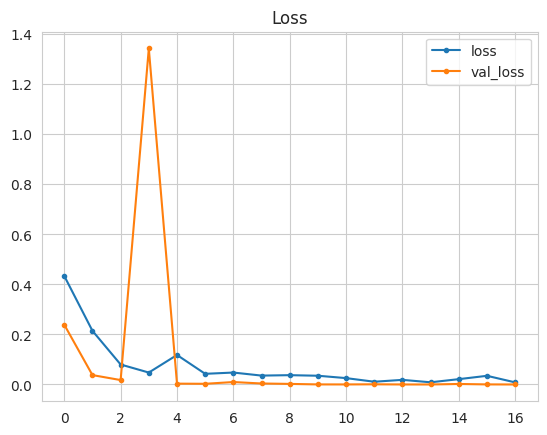

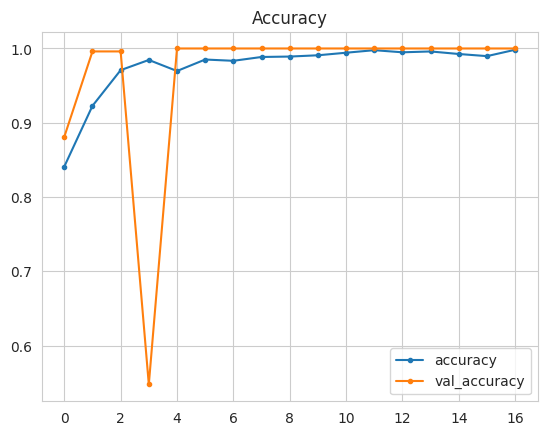

In [24]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation

Load saved model

In [25]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_project_model.h5')

Evaluate model on test set

In [26]:
evaluation = model.evaluate(test_set)

26/26 [==============================] - 4s 158ms/step - loss: 0.0045 - accuracy: 0.9980


Save evaluation pickle

In [27]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


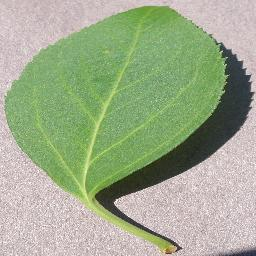

In [28]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0] # select Uninfected or Parasitized

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [29]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [30]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999431847791129
healthy


## Push files to Repo

### Push generated/new files from this Session to Github repo

* .gitignore

In [51]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

* Git status

In [52]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/ModelingAndEvaluating.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


* Git add

In [53]:
!git add .

* Git commit

In [ ]:
!git commit -am "Add new plots"

* Git push

In [54]:
!git push

Everything up-to-date
